# Predicting Passenger Satisfaction

## Framing the Problem
### Business Objective 
We want to build a model that predicts passenger satisfaction to analyze what factors affect the flying experience. From uncovering those factors for different customer groups, we can optimize on them to create a better passenger experience and in turn improve retention of product, increase customer loyalty and drive up revenue.

### The Model
We will be using 2 types of models: Logistic Regression and Support Vector Machines. Both of these models are easy to implement and interpretable.

Since logistic regression assumes a linear relationship between the explanatory and response variables while SVM can assume a non-linear relationship, we can compare these 2 models to see which one fits the data better. 

### Performance Assessment 
We will be using the F1-score and the precision-recall (PR) curve to assess and compare our models. 

We want to minimize the number of passengers that we misclassify as being satisfied (when they're actually dissatisfied) so that we can pinpoint what are areas of dissatisfaction). However, we also want to minimize the number of passengers we misclassify as not being satisfied (when they're actually satisfied) so that we can find factors that are contributing to a satisfied passenger. 

A precision-recall curve is to support our F1 score and also because we should care more about misclassifying a disatissfied passenger, from a customer experience perspective. 

### Assumptions
We're assuming that each entry of the dataset are independent from each other and that one passenger's satisfaction doesn't affect another passenger's. We're also assuming that each entry of the data is coming from the same distribution. 

In [366]:
# pyspark for EDA imports
import pyspark
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [367]:
spark = SparkSession.builder.appName('pax_satisfaction').getOrCreate()

In [368]:
pax_sat_df = spark.read.options(header = True, emptyValue = NullType).csv("/Users/huongngo/Desktop/PERSONAL PROJECTS/customer_satisfaction/data/satisfaction.csv")
print(f"dataframe type: {type(pax_sat_df)}")

dataframe type: <class 'pyspark.sql.dataframe.DataFrame'>


In [369]:
print("Columns Overview")
pd.DataFrame(pax_sat_df.dtypes, columns = ['Column', 'Data Type'])

Columns Overview


,Column,Data Type
0,id,string
1,satisfaction_v2,string
2,Gender,string
3,Customer Type,string
4,Age,string
5,Type of Travel,string
6,Class,string
7,Flight Distance,string
8,Seat comfort,string
9,Departure/Arrival time convenient,string


In [370]:
pax_sat_df.select(pax_sat_df.columns[:13]).limit(5).toPandas()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,2
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,2
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,3
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,4


In [371]:
pax_sat_df.select(pax_sat_df.columns[13:]).limit(5).toPandas()

,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,4,2,3,3,0,3,5,3,2,0,0
1,2,2,3,4,4,4,2,3,2,310,305
2,0,2,2,3,3,4,4,4,2,0,0
3,4,3,1,1,0,1,4,1,3,0,0
4,3,4,2,2,0,2,4,2,5,0,0


In [372]:
numeric_columns = pax_sat_df.columns[7:] + ['id', 'Age']
string_columns = pax_sat_df.columns[1:4] + pax_sat_df.columns[5:7]

In [373]:
for column in numeric_columns:
    pax_sat_df = pax_sat_df.withColumn(column, col(column).cast(IntegerType()))

In [374]:
print("Columns Overview")
col_overview = pd.DataFrame(pax_sat_df.dtypes, columns = ['Column', 'Data Type'])
col_overview

Columns Overview


,Column,Data Type
0,id,int
1,satisfaction_v2,string
2,Gender,string
3,Customer Type,string
4,Age,int
5,Type of Travel,string
6,Class,string
7,Flight Distance,int
8,Seat comfort,int
9,Departure/Arrival time convenient,int


In [375]:
temp_df = pax_sat_df.select([count_distinct(column).alias(column) for column in pax_sat_df.columns])
temp_df.toPandas().T

,0
id,129880
satisfaction_v2,2
Gender,2
Customer Type,2
Age,75
Type of Travel,2
Class,3
Flight Distance,5398
Seat comfort,6
Departure/Arrival time convenient,6


In [376]:
col_overview['Specific Data Type'] = ['NO', 'NO', 'NO', 'OR', 'NU', 'NO', 'OR', 'NU'] + ['OR'] * 14 + ['NU', 'NU']
col_overview

,Column,Data Type,Specific Data Type
0,id,int,NO
1,satisfaction_v2,string,NO
2,Gender,string,NO
3,Customer Type,string,OR
4,Age,int,NU
5,Type of Travel,string,NO
6,Class,string,OR
7,Flight Distance,int,NU
8,Seat comfort,int,OR
9,Departure/Arrival time convenient,int,OR


In [377]:
pax_sat_df.describe(numeric_columns).toPandas()

,summary,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,id,Age
0,count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129487,129880,129880
1,mean,1981.409054511857,2.838597166615337,2.990645210963967,2.851994148444718,2.990421927933477,3.2491299661225748,3.3834770557437635,3.519702802587003,3.4721050200184784,3.465075454265476,3.485902371419772,3.695672928857407,3.3408068986757007,3.7057591623036648,3.3525870033877427,14.713712657838004,15.09112883918849,64940.5,39.42795657530028
2,stddev,1027.115605613396,1.3929832432699039,1.5272243703451152,1.44372938657304,1.3059698939850506,1.3188175196680614,1.3460591444981043,1.306510690351753,1.3055596480285887,1.2708355823355082,1.292225983002256,1.1564833967397006,1.26058228495459,1.1517739117986903,1.2987145021407407,38.0711262150364,38.46565024011914,37493.27081846375,15.119359950371685
3,min,50,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7
4,max,6951,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1592,1584,129880,85


In [378]:
amount_missing_df = pax_sat_df.select([(count(when(pax_sat_df[column] == 0, column))/count(lit(1))) \
.alias(column) for column in numeric_columns])
amount_missing_df.toPandas()

,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,id,Age
0,0.0,0.036934,0.051309,0.045773,0.000015,0.001016,0.022929,0.000008,0.000139,0.000038,0.003419,0.0,0.000008,0.000038,0.000108,0.564798,0.560156,0.0,0.0


In [379]:
amount_missing_df = pax_sat_df.select([(count(when(isnull(column) | isnan(column), column))/count(lit(1))) \
.alias(column) for column in string_columns])
amount_missing_df.toPandas()

,satisfaction_v2,Gender,Customer Type,Type of Travel,Class
0,0.0,0.0,0.0,0.0,0.0


In [380]:
pdf = pax_sat_df.toPandas()
pdf.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,...,4,2,2,0,2,4,2,5,0,0.0


/Users/huongngo/opt/anaconda3/envs/pax_satisfaction/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

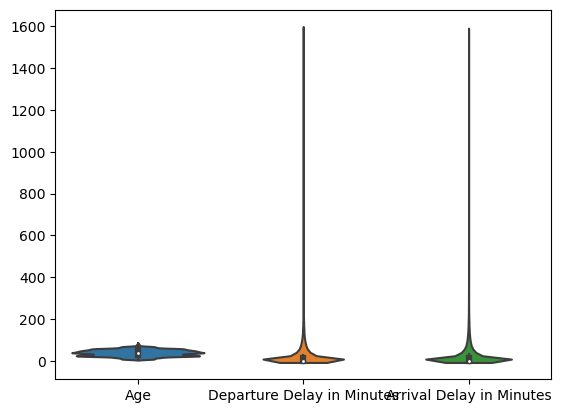

In [381]:
sns.violinplot(data = pdf[['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']])

<AxesSubplot:>

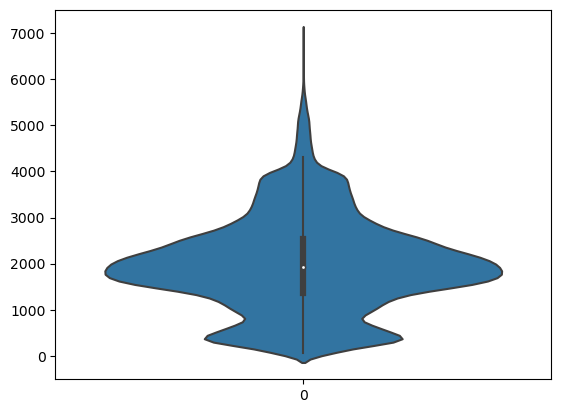

In [382]:
sns.violinplot(data = pdf['Flight Distance'])

In [383]:
seat_comfort_cnt = pd.DataFrame(pdf.groupby('Seat comfort').count()['id'])
cus_type_cnt = pd.DataFrame(pdf.groupby('Customer Type').count()['id'])
food_drink_cnt = pd.DataFrame(pdf.groupby('Food and drink').count()['id'])
gate_loc_cnt = pd.DataFrame(pdf.groupby('Gate location').count()['id'])

class_cnt = pd.DataFrame(pdf.groupby('Class').count()['id'])
conven_cnt = pd.DataFrame(pdf.groupby('Departure/Arrival time convenient').count()['id'])
wifi_cnt = pd.DataFrame(pdf.groupby('Inflight wifi service').count()['id'])
ent_cnt = pd.DataFrame(pdf.groupby('Inflight entertainment').count()['id'])

support_cnt = pd.DataFrame(pdf.groupby('Online support').count()['id'])
booking_cnt = pd.DataFrame(pdf.groupby('Ease of Online booking').count()['id'])
on_board_cnt = pd.DataFrame(pdf.groupby('On-board service').count()['id'])
leg_room_cnt = pd.DataFrame(pdf.groupby('Leg room service').count()['id'])

baggage_cnt = pd.DataFrame(pdf.groupby('Baggage handling').count()['id'])
checkin_cnt = pd.DataFrame(pdf.groupby('Checkin service').count()['id'])
clean_cnt = pd.DataFrame(pdf.groupby('Cleanliness').count()['id'])
boarding_cnt = pd.DataFrame(pdf.groupby('Online boarding').count()['id'])

<AxesSubplot:xlabel='Gate location', ylabel='id'>

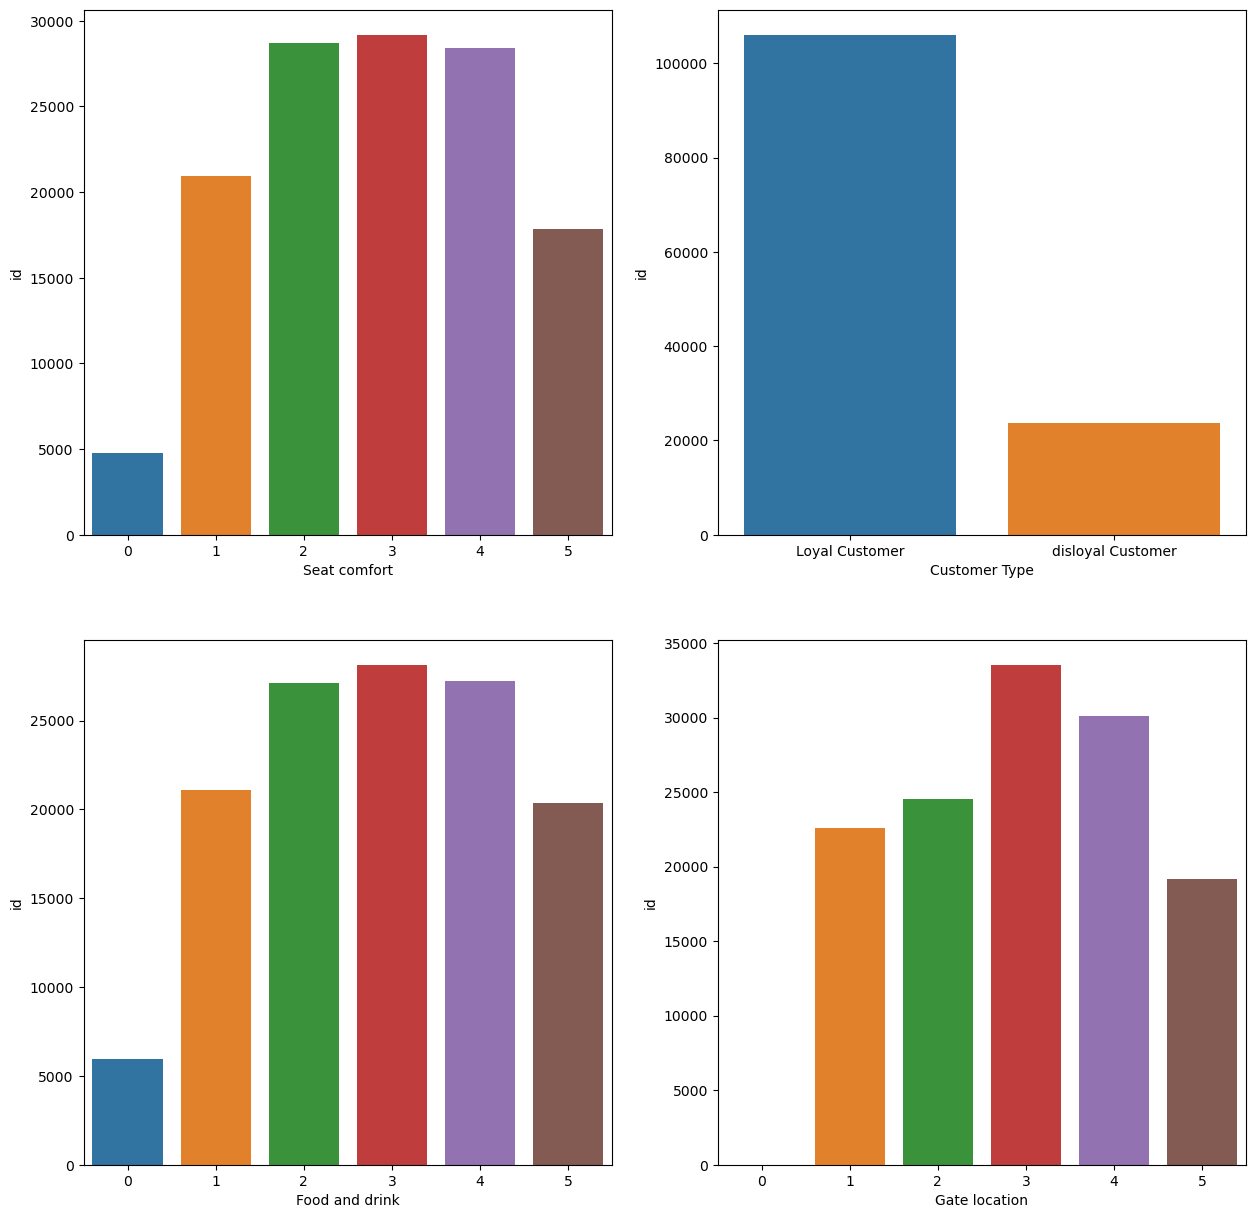

In [384]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = seat_comfort_cnt, x = seat_comfort_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = cus_type_cnt, x = cus_type_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = food_drink_cnt, x = food_drink_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = gate_loc_cnt, x = gate_loc_cnt.index, y = 'id')

<AxesSubplot:xlabel='Inflight entertainment', ylabel='id'>

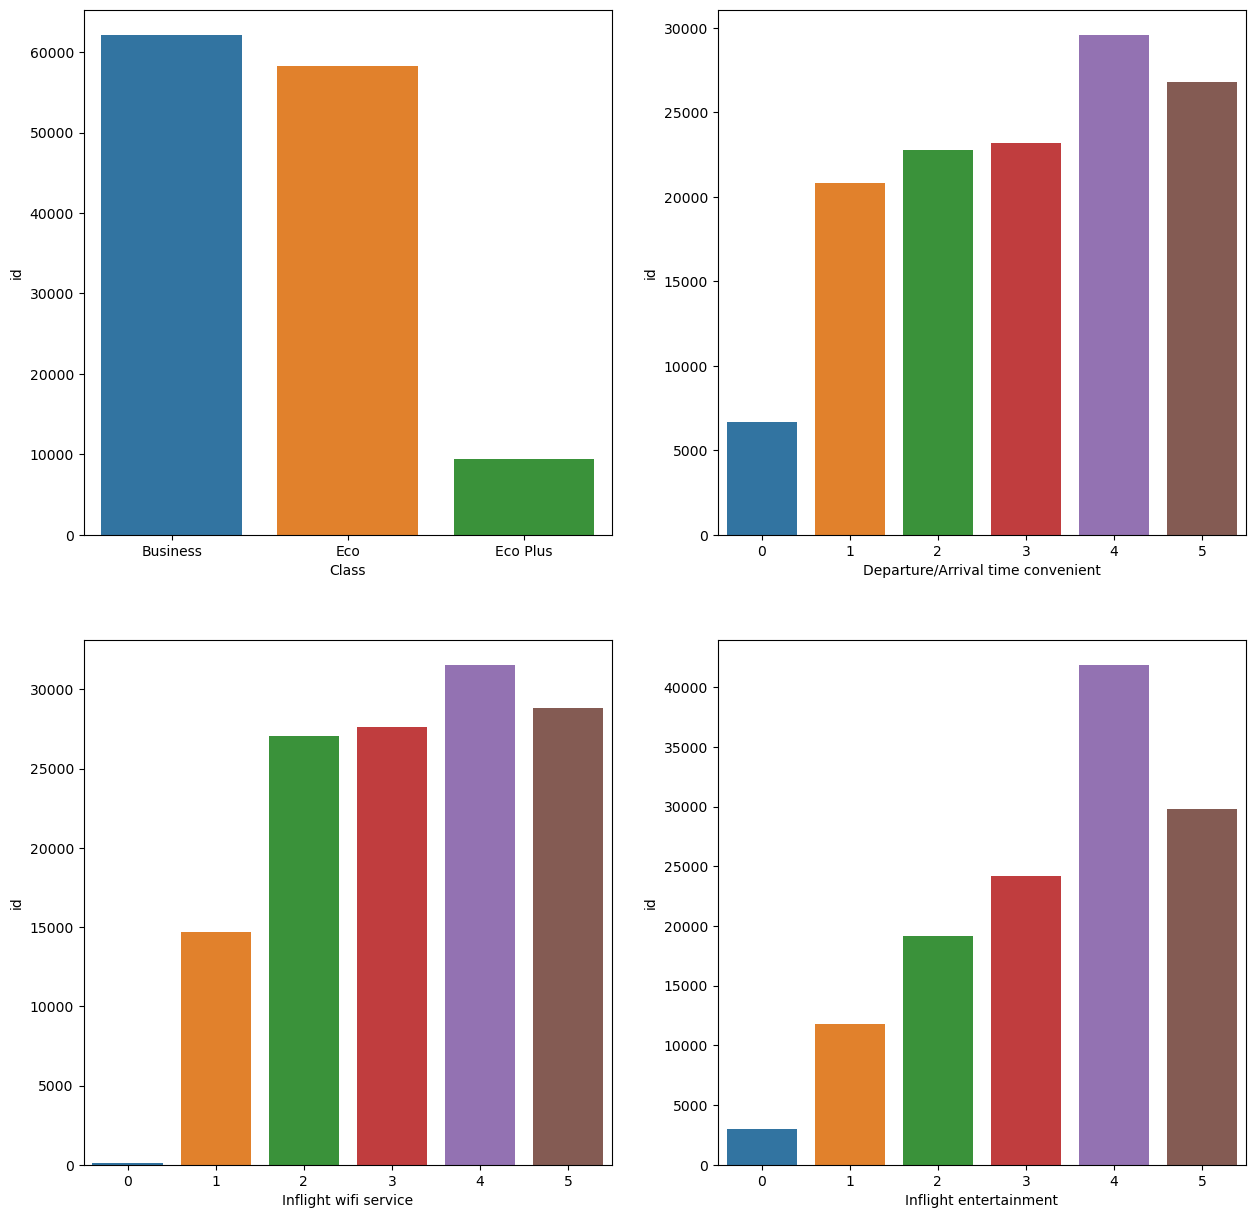

In [385]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = class_cnt, x = class_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = conven_cnt, x = conven_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = wifi_cnt, x = wifi_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = ent_cnt, x = ent_cnt.index, y = 'id')

<AxesSubplot:xlabel='Leg room service', ylabel='id'>

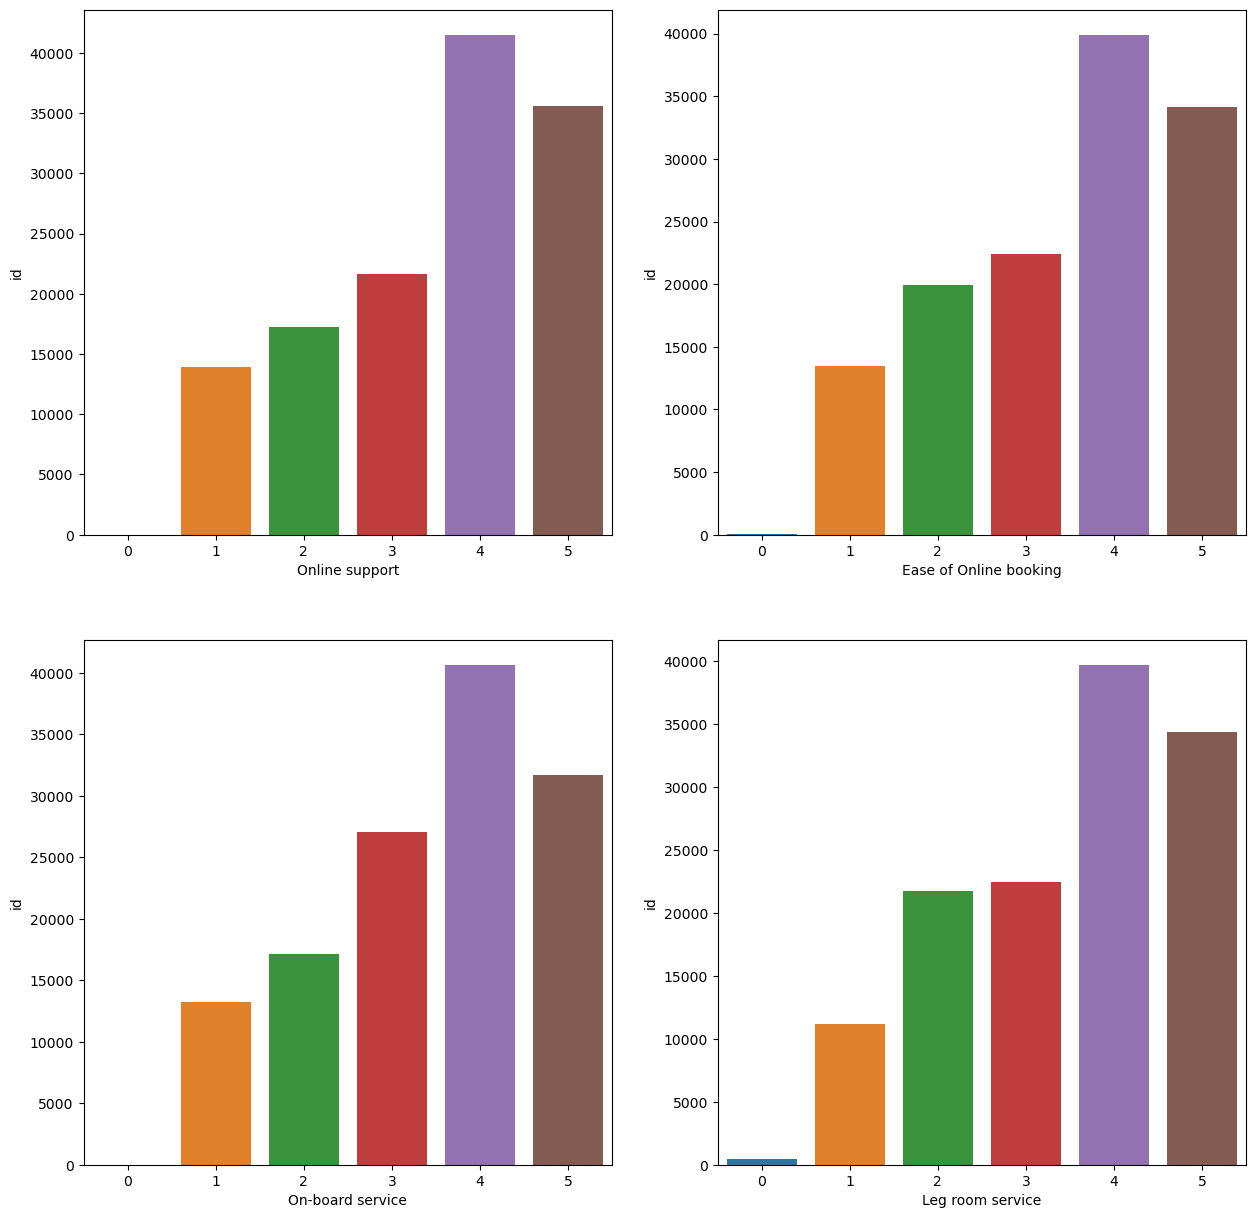

In [386]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = support_cnt, x = support_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = booking_cnt, x = booking_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = on_board_cnt, x = on_board_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = leg_room_cnt, x = leg_room_cnt.index, y = 'id')

<AxesSubplot:xlabel='Online boarding', ylabel='id'>

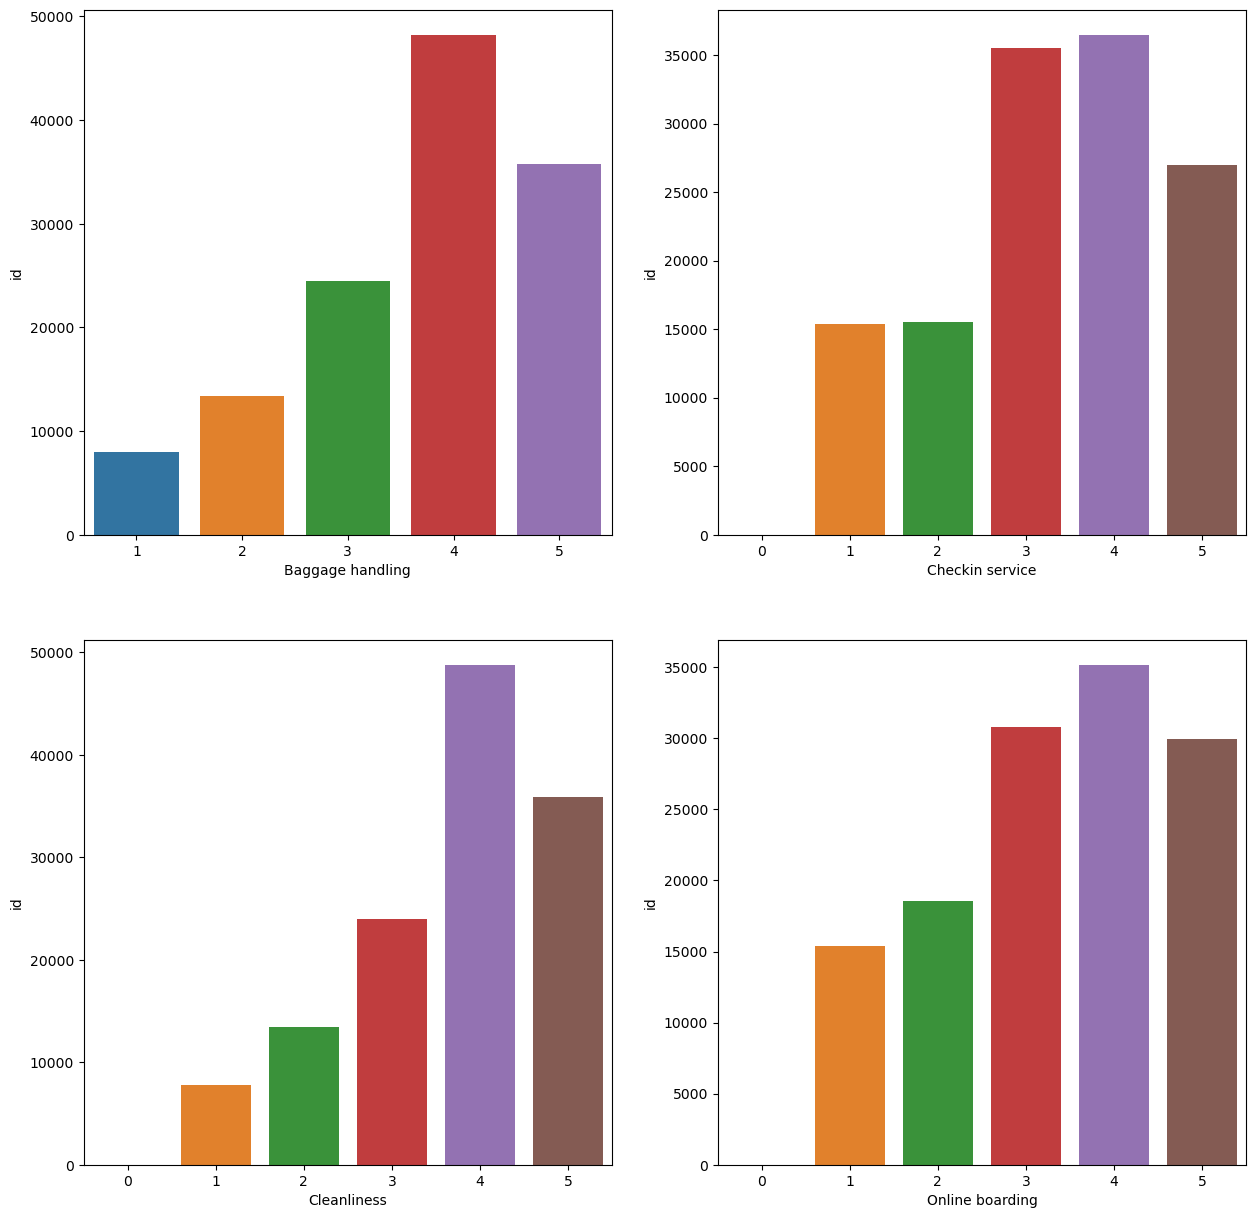

In [387]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = baggage_cnt, x = baggage_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = checkin_cnt, x = checkin_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = clean_cnt, x = clean_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = boarding_cnt, x = boarding_cnt.index, y = 'id')

In [388]:
pax_sat_df = pax_sat_df.replace(0, None)
amount_missing_df = pax_sat_df.select([(count(when(isnull(column), column))/count(lit(1))) \
.alias(column) for column in numeric_columns])
amount_missing_df.toPandas()

,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,id,Age
0,0.0,0.036934,0.051309,0.045773,0.000015,0.001016,0.022929,0.000008,0.000139,0.000038,0.003419,0.0,0.000008,0.000038,0.000108,0.564798,0.563181,0.0,0.0


In [389]:
pax_sat_df_dropna = pax_sat_df.na.drop('any')
pax_sat_df_dropna.toPandas().shape

(39888, 24)

In [390]:
# imports for imputation of missing values
from pyspark.ml.feature import Imputer

In [391]:
imputer = Imputer(strategy = 'median')
imputer.setInputCols(numeric_columns[1:11] + numeric_columns[12:15])
imputer.setOutputCols([f'out_{column}' for column in (numeric_columns[1:11] + numeric_columns[12:15])])

Imputer_8526de609d08

In [392]:
imputer.getRelativeError()

0.001

In [393]:
numeric_columns

['Flight Distance',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Food and drink',
 'Gate location',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Cleanliness',
 'Online boarding',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes',
 'id',
 'Age']

In [394]:
model = imputer.fit(pax_sat_df)
model.setInputCols(numeric_columns[1:11] + numeric_columns[12:15])

ImputerModel: uid=Imputer_8526de609d08, strategy=median, missingValue=NaN, numInputCols=13, numOutputCols=13

In [395]:
pax_sat_df_impute = model.transform(pax_sat_df)
pax_sat_df_impute.select('*').limit(5).toPandas()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,out_Gate location,out_Inflight wifi service,out_Inflight entertainment,out_Online support,out_Ease of Online booking,out_On-board service,out_Leg room service,out_Checkin service,out_Cleanliness,out_Online boarding
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,NaN,NaN,...,2,2,4,2,3,3,4,5,3,2
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,NaN,NaN,...,3,3,2,2,3,4,4,2,3,2
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,NaN,NaN,...,3,2,4,2,2,3,3,4,4,2
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,NaN,NaN,...,3,3,4,3,1,1,4,4,1,3
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,NaN,NaN,...,3,4,3,4,2,2,4,4,2,5


In [396]:
for column in numeric_columns[1:11] + numeric_columns[12:15]:
    pax_sat_df_impute = pax_sat_df_impute.drop(column)

In [397]:
print(pax_sat_df_impute.columns)

['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Baggage handling', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'out_Seat comfort', 'out_Departure/Arrival time convenient', 'out_Food and drink', 'out_Gate location', 'out_Inflight wifi service', 'out_Inflight entertainment', 'out_Online support', 'out_Ease of Online booking', 'out_On-board service', 'out_Leg room service', 'out_Checkin service', 'out_Cleanliness', 'out_Online boarding']


In [398]:
for i, column in enumerate(pax_sat_df_impute.columns[11:]):
    pax_sat_df_impute = pax_sat_df_impute.withColumnRenamed(column, column[4:])
print(pax_sat_df_impute.columns)
pax_sat_df = pax_sat_df_impute


['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Baggage handling', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Checkin service', 'Cleanliness', 'Online boarding']


In [399]:
pdf = pax_sat_df.toPandas()

In [400]:
seat_comfort_cnt = pd.DataFrame(pdf.groupby('Seat comfort').count()['id'])
cus_type_cnt = pd.DataFrame(pdf.groupby('Customer Type').count()['id'])
food_drink_cnt = pd.DataFrame(pdf.groupby('Food and drink').count()['id'])
gate_loc_cnt = pd.DataFrame(pdf.groupby('Gate location').count()['id'])

class_cnt = pd.DataFrame(pdf.groupby('Class').count()['id'])
conven_cnt = pd.DataFrame(pdf.groupby('Departure/Arrival time convenient').count()['id'])
wifi_cnt = pd.DataFrame(pdf.groupby('Inflight wifi service').count()['id'])
ent_cnt = pd.DataFrame(pdf.groupby('Inflight entertainment').count()['id'])

support_cnt = pd.DataFrame(pdf.groupby('Online support').count()['id'])
booking_cnt = pd.DataFrame(pdf.groupby('Ease of Online booking').count()['id'])
on_board_cnt = pd.DataFrame(pdf.groupby('On-board service').count()['id'])
leg_room_cnt = pd.DataFrame(pdf.groupby('Leg room service').count()['id'])

baggage_cnt = pd.DataFrame(pdf.groupby('Baggage handling').count()['id'])
checkin_cnt = pd.DataFrame(pdf.groupby('Checkin service').count()['id'])
clean_cnt = pd.DataFrame(pdf.groupby('Cleanliness').count()['id'])
boarding_cnt = pd.DataFrame(pdf.groupby('Online boarding').count()['id'])

<AxesSubplot:xlabel='Gate location', ylabel='id'>

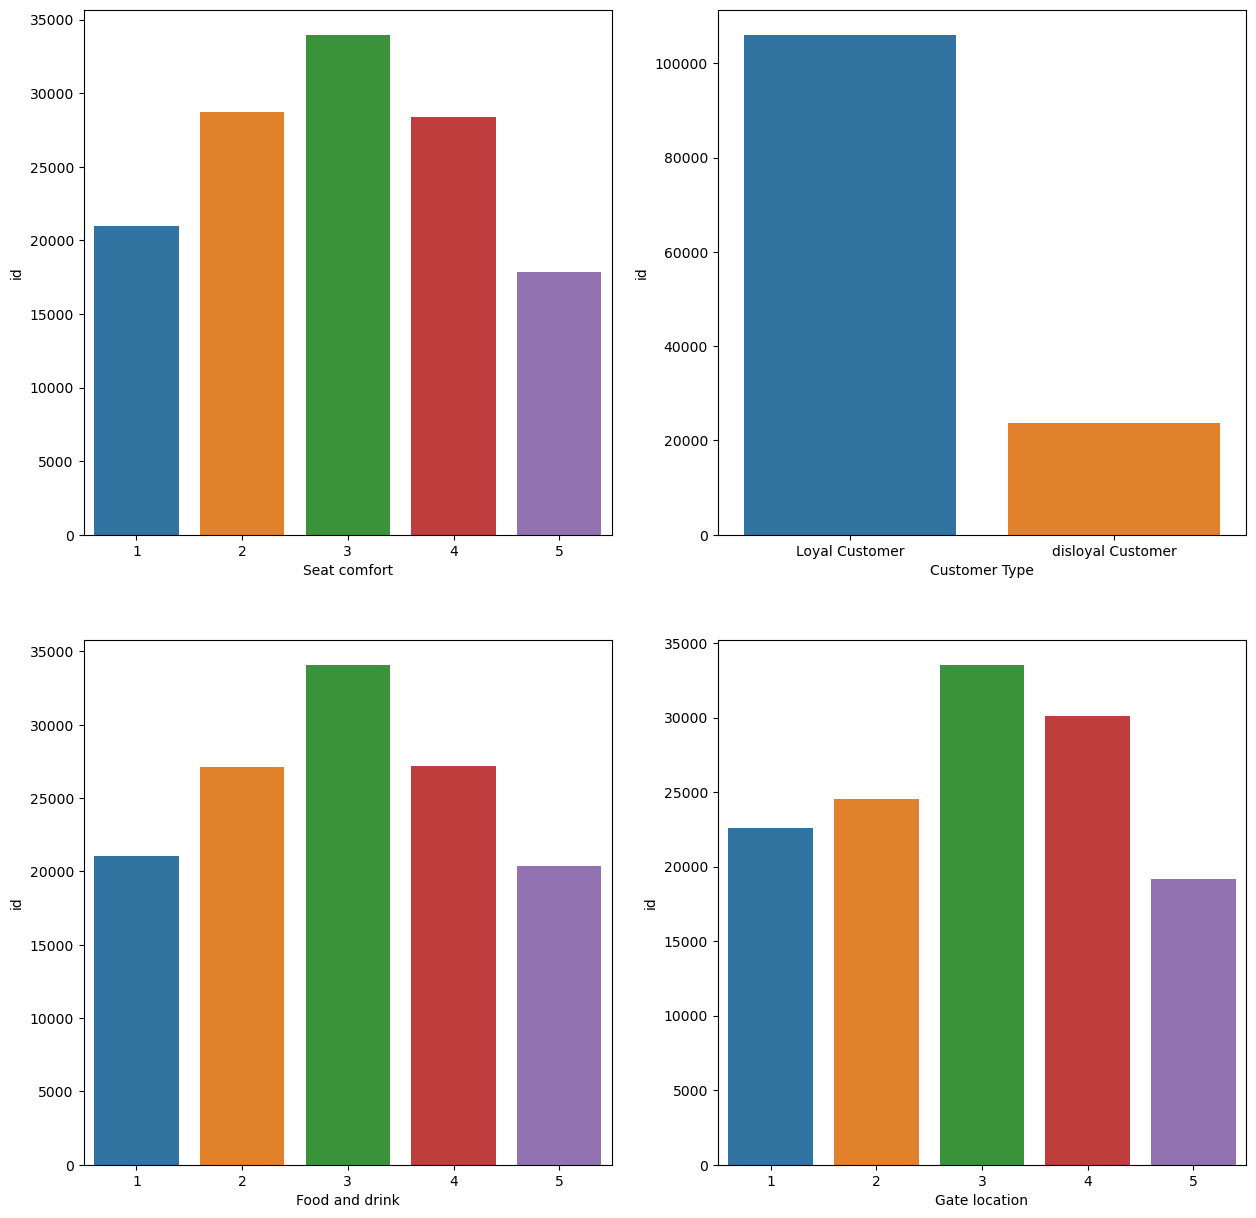

In [401]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = seat_comfort_cnt, x = seat_comfort_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = cus_type_cnt, x = cus_type_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = food_drink_cnt, x = food_drink_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = gate_loc_cnt, x = gate_loc_cnt.index, y = 'id')

<AxesSubplot:xlabel='Inflight entertainment', ylabel='id'>

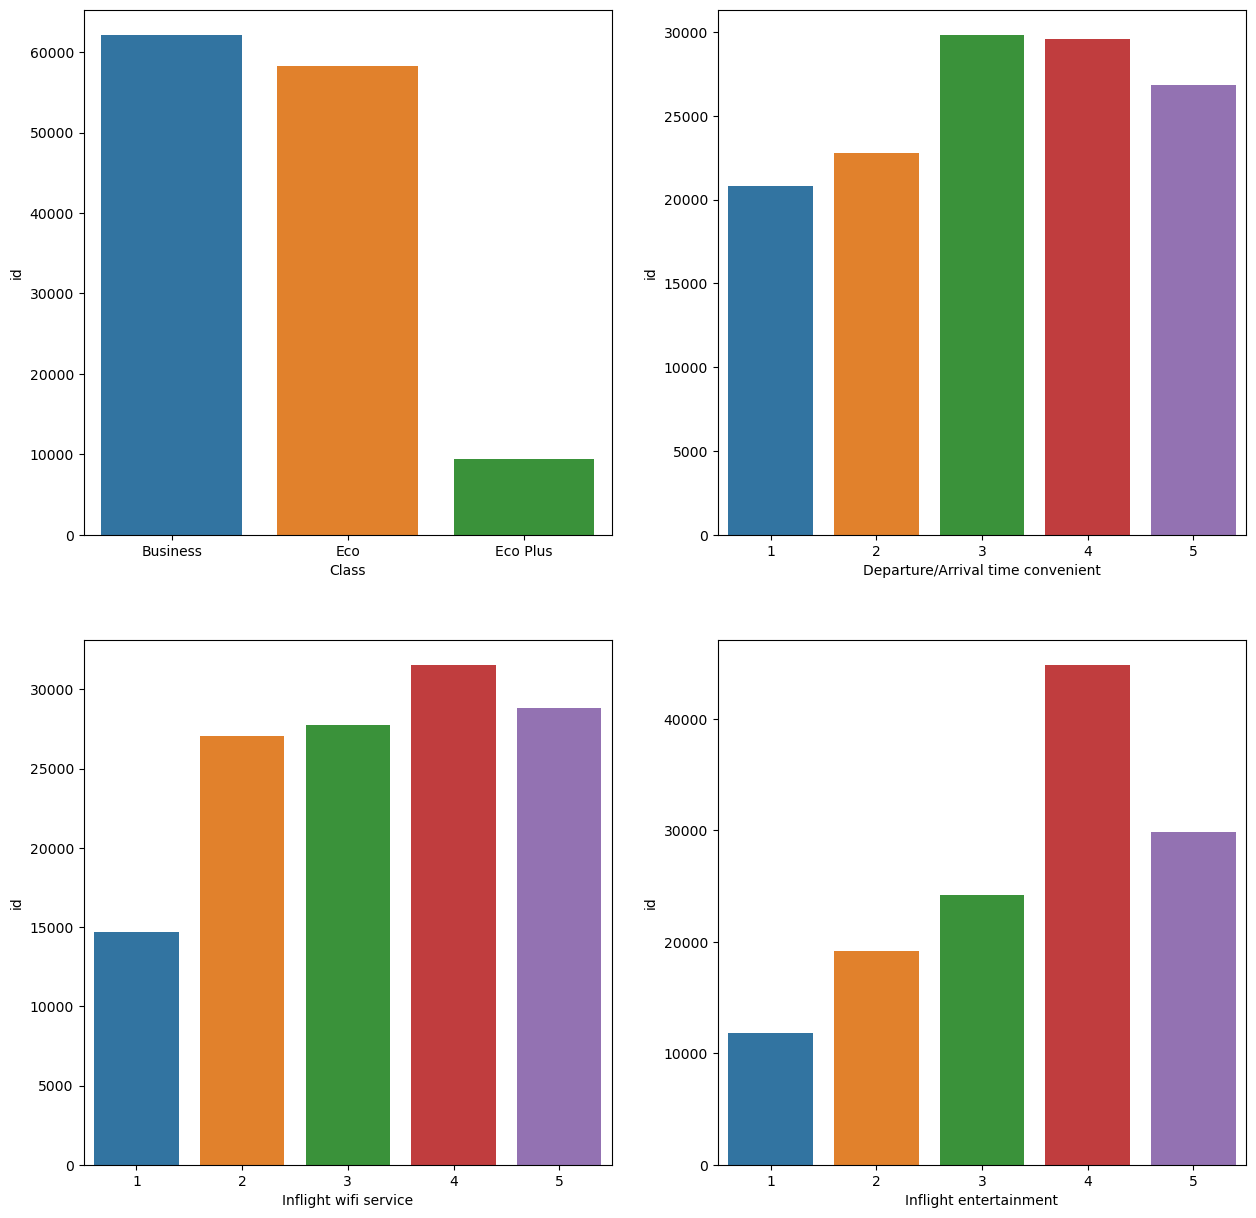

In [402]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = class_cnt, x = class_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = conven_cnt, x = conven_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = wifi_cnt, x = wifi_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = ent_cnt, x = ent_cnt.index, y = 'id')

<AxesSubplot:xlabel='Leg room service', ylabel='id'>

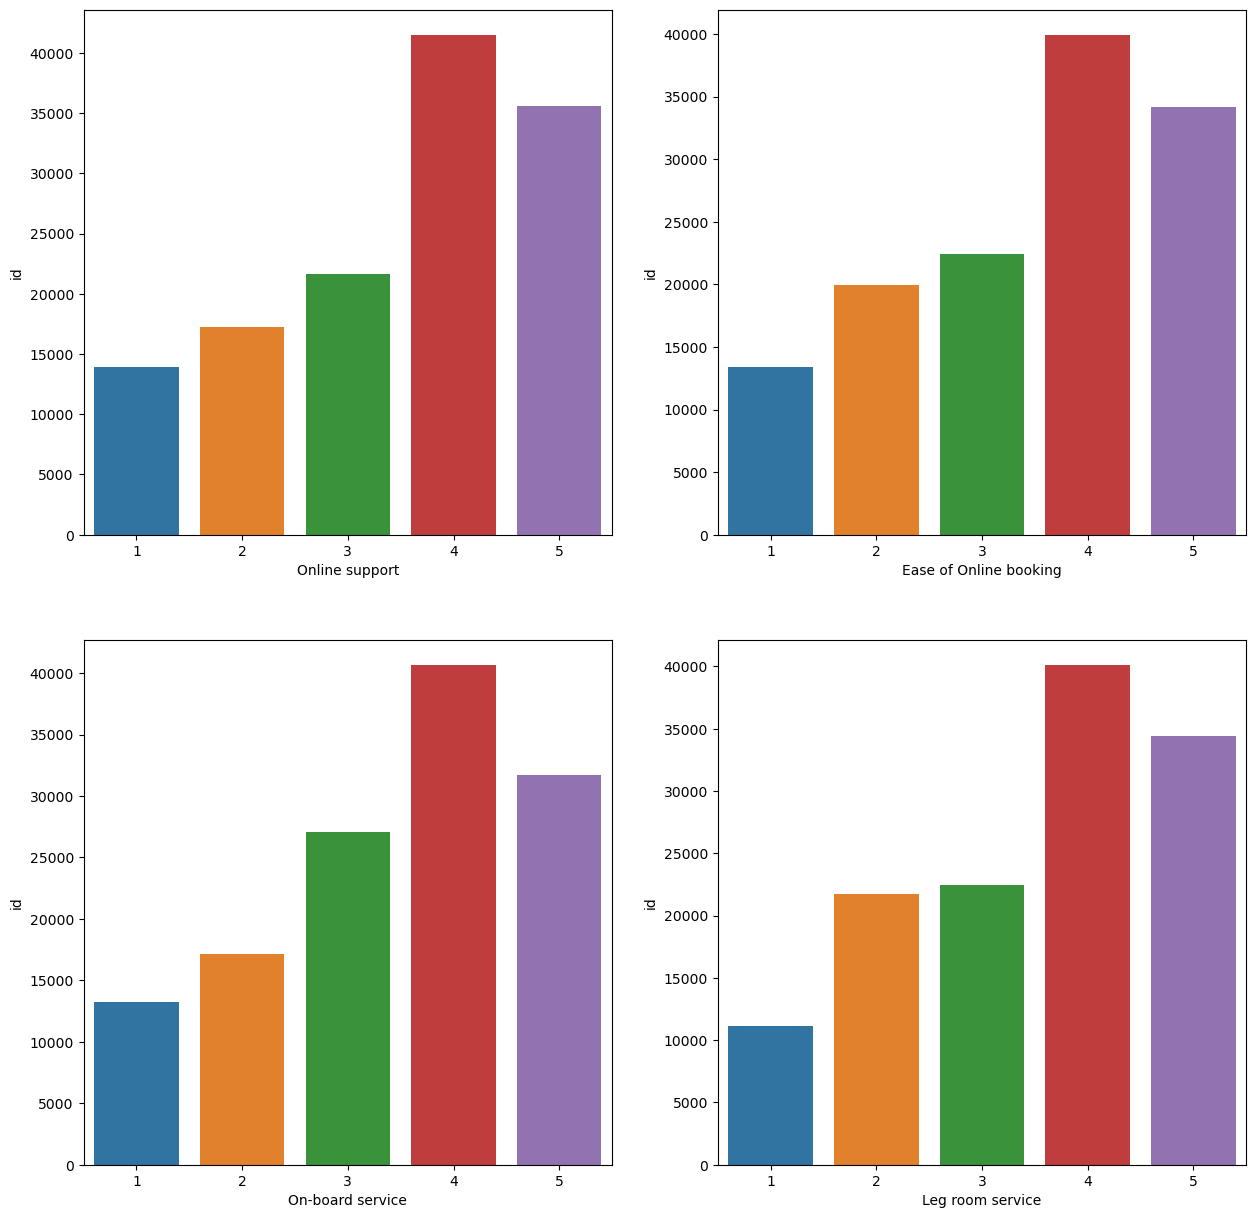

In [403]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = support_cnt, x = support_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = booking_cnt, x = booking_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = on_board_cnt, x = on_board_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = leg_room_cnt, x = leg_room_cnt.index, y = 'id')

<AxesSubplot:xlabel='Online boarding', ylabel='id'>

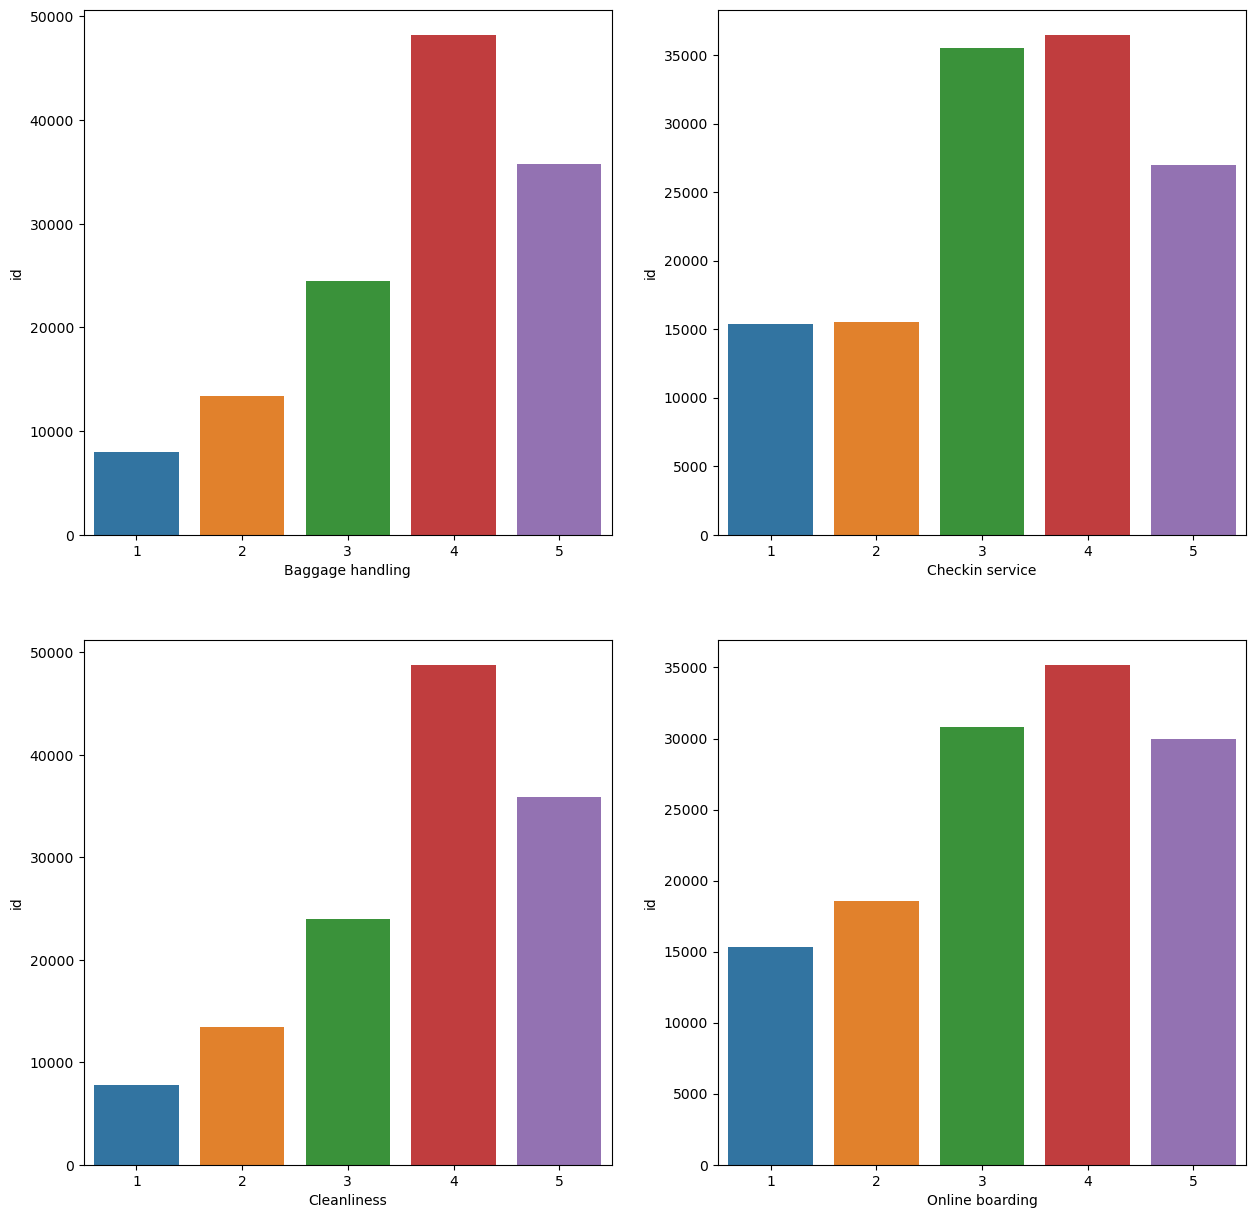

In [404]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
sns.barplot(ax = axes[0, 0], data = baggage_cnt, x = baggage_cnt.index, y = 'id')
sns.barplot(ax = axes[0, 1], data = checkin_cnt, x = checkin_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 0], data = clean_cnt, x = clean_cnt.index, y = 'id')
sns.barplot(ax = axes[1, 1], data = boarding_cnt, x = boarding_cnt.index, y = 'id')

In [407]:
pax_sat_df_num = pax_sat_df.select(numeric_columns)
pdf = pax_sat_df_num.toPandas()

In [409]:
pdf.columns

Index(['Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
       'Food and drink', 'Gate location', 'Inflight wifi service',
       'Inflight entertainment', 'Online support', 'Ease of Online booking',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'id', 'Age'],
      dtype='object')

<AxesSubplot:>

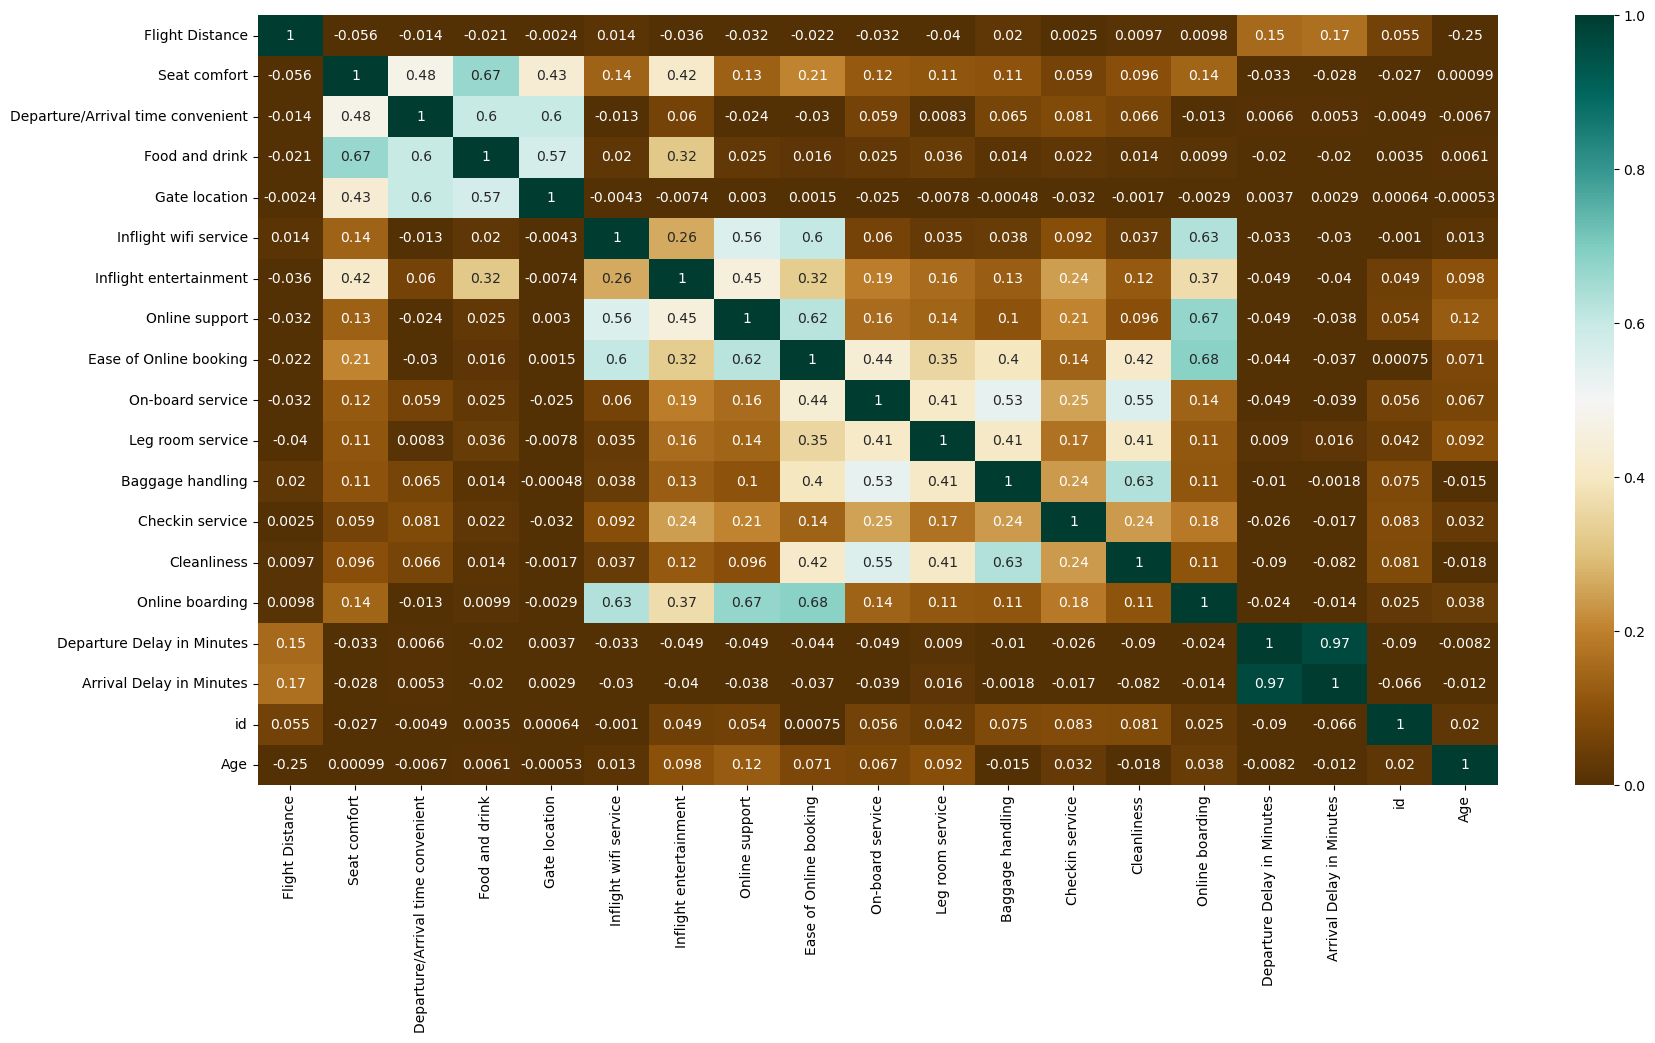

In [421]:
plt.figure(figsize = (20, 10))
sns.heatmap(pdf.corr(), vmin = 0, vmax = 1, annot = True, cmap = 'BrBG')